<a href="https://colab.research.google.com/github/Blockchain-Framework/bitcoin-anomaly-analysis/blob/develop/Notebooks/Bitcoin_general_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd

In [3]:
dataset = pd.read_csv("/content/drive/MyDrive/bitcoin_feature_filtered_dataset.csv")

In [4]:
df = dataset.copy()

In [5]:
df.columns

Index(['label', 'input_transaction_count', 'output_transaction_count',
       'input_value_mean', 'input_value_median', 'input_value_maximum',
       'input_value_minimum', 'input_value_25th_percentile',
       'input_value_75th_percentile', 'input_value_range',
       'input_spending_value_usd_mean', 'input_spending_value_usd_median',
       'input_spending_value_usd_maximum', 'input_spending_value_usd_minimum',
       'input_spending_value_usd_25th_percentile',
       'input_spending_value_usd_75th_percentile',
       'input_spending_value_usd_range', 'input_time_diff_mean',
       'input_time_diff_median', 'input_time_diff_maximum',
       'input_time_diff_minimum', 'input_time_diff_25th_percentile',
       'input_time_diff_75th_percentile', 'input_time_diff_range',
       'output_value_usd_mean', 'output_value_usd_median',
       'output_value_usd_maximum', 'output_value_usd_minimum',
       'output_value_usd_25th_percentile', 'output_value_usd_75th_percentile',
       'output_valu

In [6]:
len(df.columns)

63

In [7]:
null_counts = df.isnull().sum()
for column, count in null_counts.items():
    print(f"Column: {column}, Null Count: {count}")

Column: label, Null Count: 0
Column: input_transaction_count, Null Count: 0
Column: output_transaction_count, Null Count: 0
Column: input_value_mean, Null Count: 0
Column: input_value_median, Null Count: 0
Column: input_value_maximum, Null Count: 0
Column: input_value_minimum, Null Count: 0
Column: input_value_25th_percentile, Null Count: 0
Column: input_value_75th_percentile, Null Count: 0
Column: input_value_range, Null Count: 0
Column: input_spending_value_usd_mean, Null Count: 0
Column: input_spending_value_usd_median, Null Count: 0
Column: input_spending_value_usd_maximum, Null Count: 0
Column: input_spending_value_usd_minimum, Null Count: 0
Column: input_spending_value_usd_25th_percentile, Null Count: 0
Column: input_spending_value_usd_75th_percentile, Null Count: 0
Column: input_spending_value_usd_range, Null Count: 0
Column: input_time_diff_mean, Null Count: 0
Column: input_time_diff_median, Null Count: 0
Column: input_time_diff_maximum, Null Count: 0
Column: input_time_diff_mi

In [5]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 3.2 MB/s eta 0:00:00


In [6]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.5/533.5 kB 6.1 MB/s eta 0:00:00


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc
import numpy as np
import shap
import matplotlib.pyplot as plt

# Build Simple Model

In [6]:
X = df.drop(['label'], axis=1)  # Features
y = df['label']  # Target

X_train_strat, X_test_strat, y_train_strat, y_test_strat = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_strat)
X_test_scaled = scaler.transform(X_test_strat)

In [7]:
original_feature_names = X.columns

X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=original_feature_names)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=original_feature_names)

Random Forest Model

Test Accuracy: 0.6803453301939679
Ensemble F1 score: 0.6779666539188844


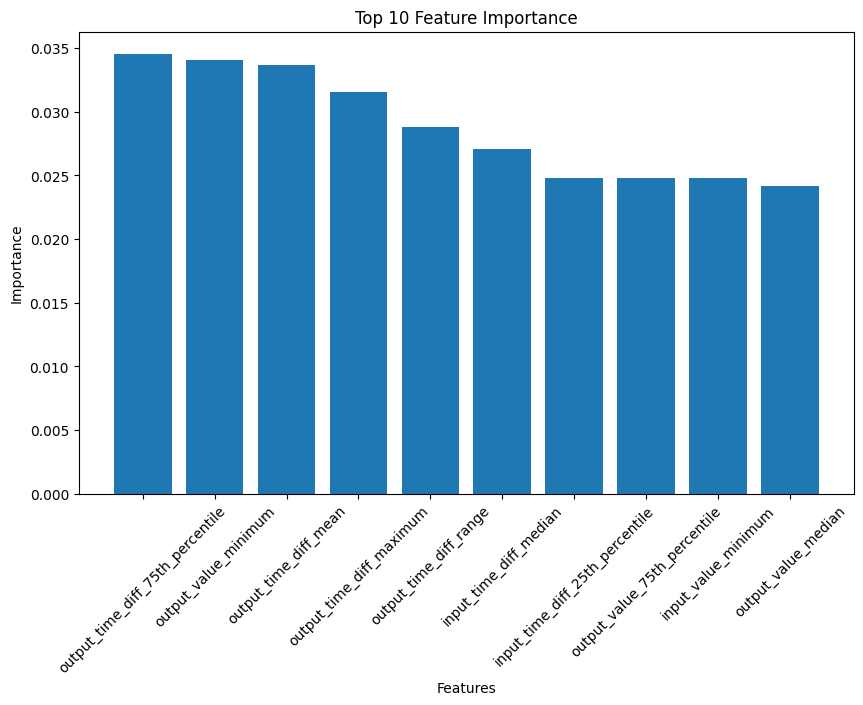

In [14]:
rf = RandomForestClassifier(max_depth=13, n_estimators=200, random_state=42)
rf.fit(X_train_scaled_df, y_train_strat)

y_pred_test = rf.predict(X_test_scaled_df)
print(f"Test Accuracy: {accuracy_score(y_test_strat, y_pred_test)}")

f1 = f1_score(y_test_strat, y_pred_test, average='weighted')
print(f"Ensemble F1 score: {f1}")

# Feature Importance
feature_importance = rf.feature_importances_
indices = np.argsort(feature_importance)[::-1][:10]  # Indices of top 10 features
top_features = X.columns[indices]
top_importances = feature_importance[indices]

plt.figure(figsize=(10, 6))  # Adjusted figure size
plt.bar(top_features, top_importances)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Top 10 Feature Importance')
plt.xticks(rotation=45)  # Rotate feature names for better visibility
plt.show()

In [ ]:
# SHAP Values
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test_scaled_df)

# Plot SHAP values for the first prediction
# shap.initjs()
# shap.force_plot(explainer.expected_value[0], shap_values[0][0], X_test_scaled[0], feature_names=X.columns)

# SHAP Values - Summary Plot with actual feature names
plt.figure(figsize=(20, 20))  # Adjust figure size as needed
shap.summary_plot(shap_values, X_test_scaled_df, plot_type="bar")

XGBoost

Test Accuracy: 0.6880816235003924
Ensemble F1 score: 0.6865185273564867


[06:21:09] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


<Figure size 2000x1000 with 0 Axes>

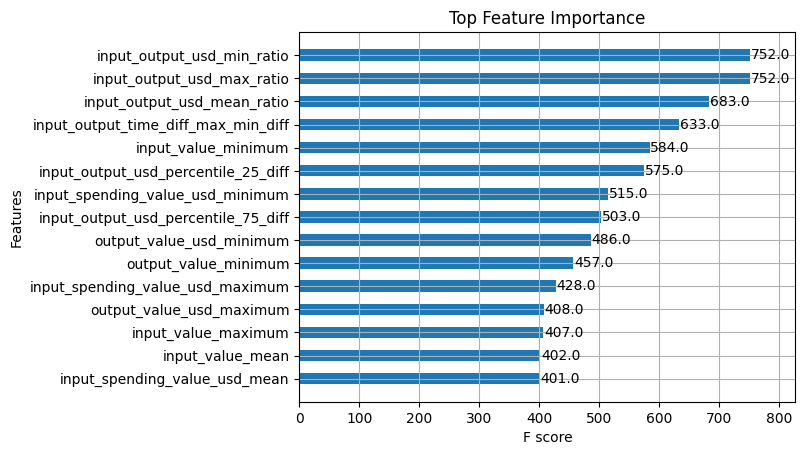

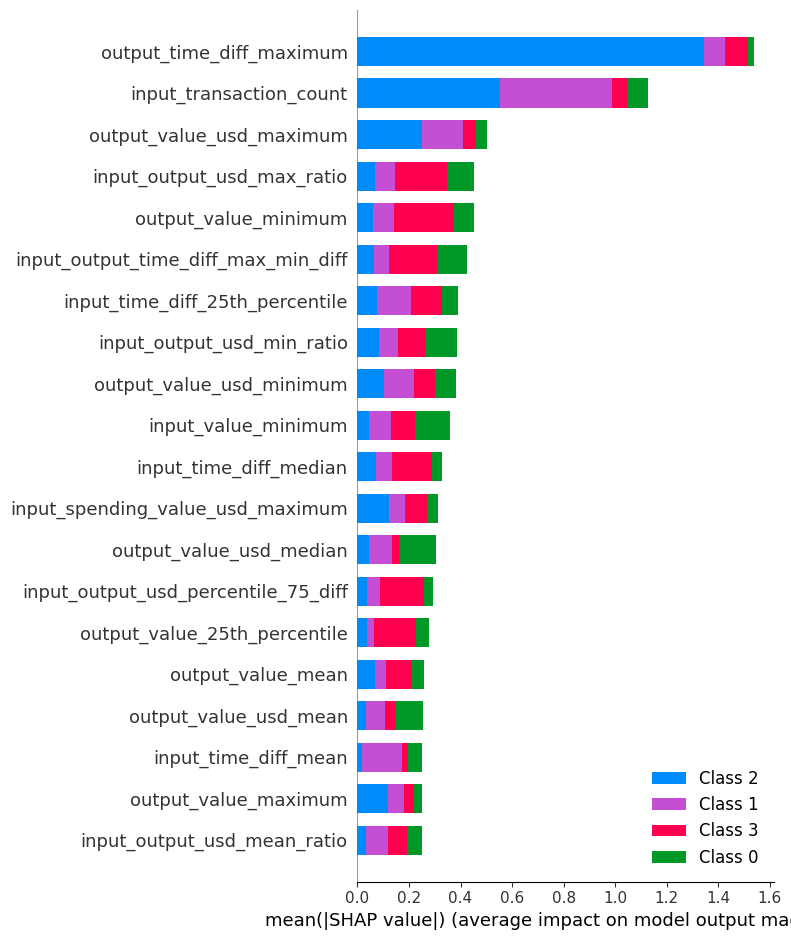

In [9]:
import xgboost as xgb

original_feature_names = X.columns

X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=original_feature_names)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=original_feature_names)

# Train the model
model_xbg = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model_xbg.fit(X_train_scaled_df, y_train_strat)

# Make predictions and print metrics
y_pred_test = model_xbg.predict(X_test_scaled_df)
print(f"Test Accuracy: {accuracy_score(y_test_strat, y_pred_test)}")
f1 = f1_score(y_test_strat, y_pred_test, average='weighted')
print(f"Ensemble F1 score: {f1}")

# SHAP Values
explainer = shap.TreeExplainer(model_xbg)
shap_values = explainer.shap_values(X_test_scaled_df)

# Feature Importance with actual feature names
num_features = 15  # Number of top features to display
sorted_idx = model_xbg.feature_importances_.argsort()
plt.figure(figsize=(20, 10))  # Adjust figure size as needed
xgb.plot_importance(model_xbg, max_num_features=num_features, importance_type='weight', height=0.5)
plt.title('Top Feature Importance')
plt.show()

# SHAP Values - Summary Plot with actual feature names
plt.figure(figsize=(20, 20))  # Adjust figure size as needed
shap.summary_plot(shap_values, X_test_scaled_df, plot_type="bar")

CatBoost

Test Accuracy: 0.6884179840789326
Ensemble F1 score: 0.6866749141011507


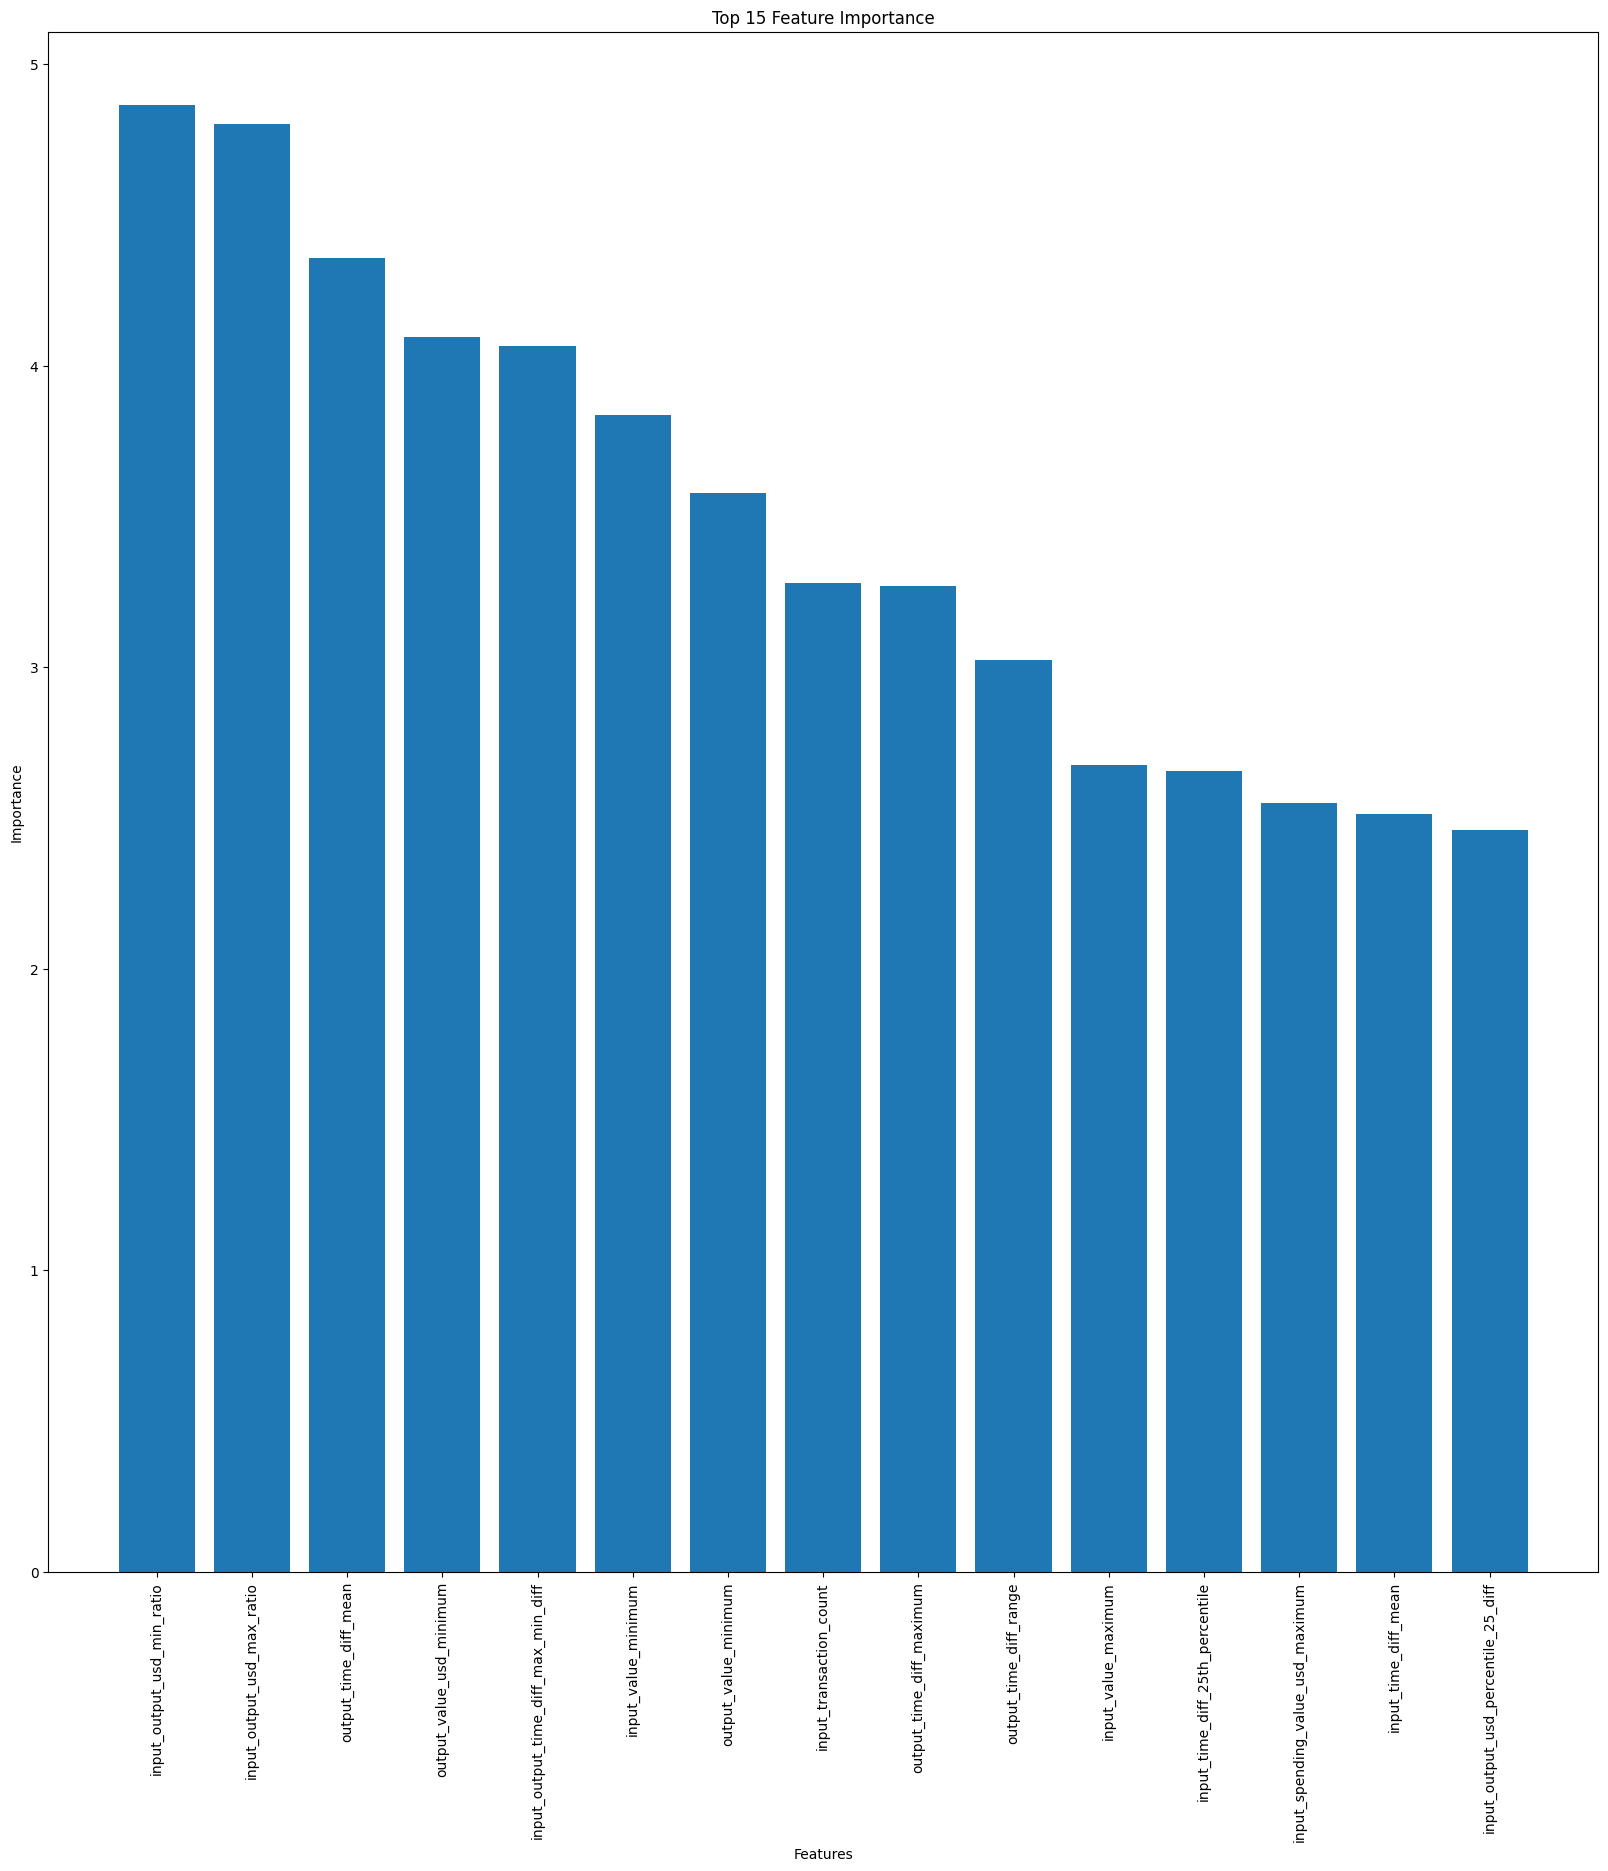

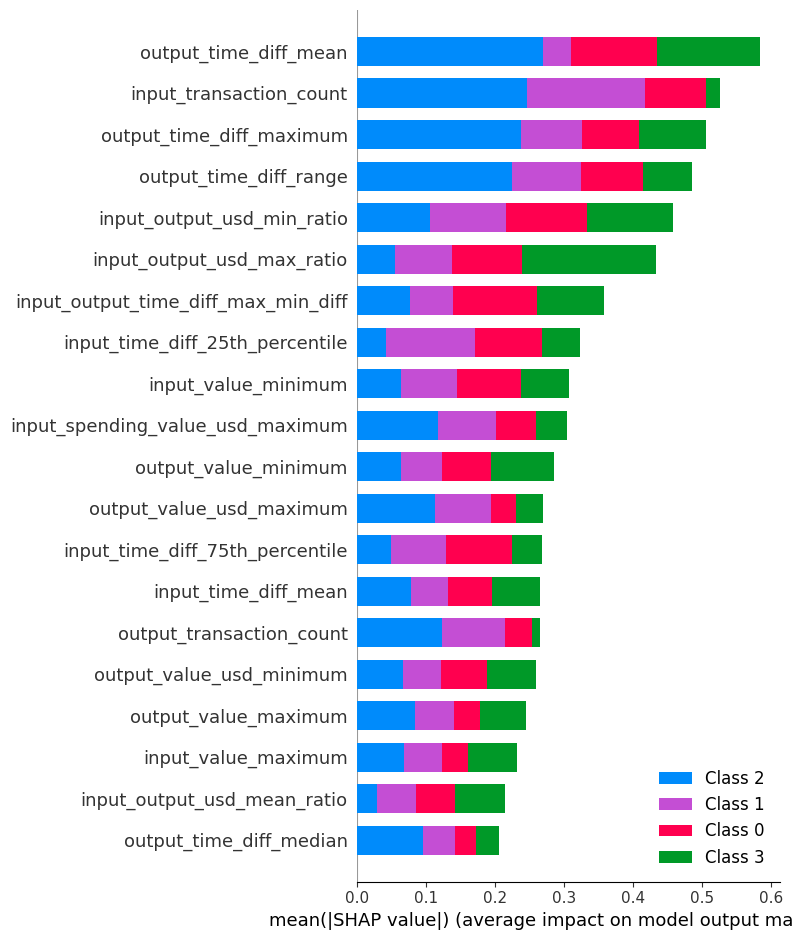

In [10]:
import catboost as cb

original_feature_names = X.columns

X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=original_feature_names)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=original_feature_names)

model_cb = cb.CatBoostClassifier(verbose=0, random_state=42)
model_cb.fit(X_train_scaled_df, y_train_strat)

# Make predictions and print metrics
y_pred_test = model_cb.predict(X_test_scaled_df)
print(f"Test Accuracy: {accuracy_score(y_test_strat, y_pred_test)}")
f1 = f1_score(y_test_strat, y_pred_test, average='weighted')
print(f"Ensemble F1 score: {f1}")

# Feature Importance for Top 15 Features
feature_importances = model_cb.get_feature_importance()
indices = np.argsort(feature_importances)[::-1][:15]  # Indices of top 15 features
top_features = X.columns[indices]
top_importances = feature_importances[indices]

plt.figure(figsize=(20, 10))  # Custom size
plt.bar(range(len(top_importances)), top_importances)
plt.xticks(range(len(top_importances)), top_features, rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Top 15 Feature Importance')
plt.show()

# SHAP Values
explainer = shap.TreeExplainer(model_cb)
shap_values = explainer.shap_values(X_test_scaled_df)

# SHAP Summary Plot for all features
plt.figure(figsize=(20, 20))  # Custom size
shap.summary_plot(shap_values, X_test_scaled_df, plot_type="bar")

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, make_scorer
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

def feature_selection_rfe_cv(X, y, n_splits=5):
    """
    Perform feature selection using Recursive Feature Elimination (RFE) with cross-validation.

    :param X: Feature DataFrame
    :param y: Target variable
    :param n_splits: Number of folds for K-Fold Cross-Validation
    :return: DataFrame with feature subset performance
    """
    # Normalizing data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

    rf = RandomForestClassifier(max_depth=20, n_estimators=200, random_state=42)
    skf = StratifiedKFold(n_splits=n_splits)

    feature_subset_performance = []

    for i in range(10, min(60, X_scaled.shape[1] + 1), 10):
        rfe = RFE(estimator=rf, n_features_to_select=i, step=1)
        rfe.fit(X_scaled, y)

        # Get the mask of the selected features
        selected_features = X_scaled.columns[rfe.support_]

        # Cross-Validation for each feature subset
        cv_accuracy = cross_val_score(rf, X_scaled[selected_features], y, cv=skf, scoring='accuracy')
        cv_f1 = cross_val_score(rf, X_scaled[selected_features], y, cv=skf, scoring=make_scorer(f1_score, average='weighted'))

        feature_subset_performance.append({
            'Num Features': i,
            'Selected Features': selected_features.tolist(),
            'CV Accuracy': np.mean(cv_accuracy),
            'CV F1 Score': np.mean(cv_f1)
        })

    return pd.DataFrame(feature_subset_performance)



In [ ]:
feature_performance = feature_selection_rfe_cv(X, y, n_splits=5)
print(feature_performance)